In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import awkward as ak
import seaborn as sn
from fast_histogram import histogram2d

In [100]:
#/disk/atlas3/data_MC/ATLASOpen/jets/part1.root
#/disk/atlas3/data_MC/delphes/ttbar_13TeV_taus_1000events.root:Delphes #PYTHIA ttbar
#/disk/atlas3/data_MC/delphes/ttbar_40_120_20_1000events.root:Delphes
#/disk/atlas3/data_MC/delphes/directW_13TeV_taus_100_40_1000events.root:Delphes
#/disk/atlas3/data_MC/delphes/directW_13TeV_taus_100_1000events.root:Delphes"
#/disk/atlas3/data_MC/delphes/higgs_13TeV_taus_1000events.root:Delphes 
#/disk/atlas3/data_MC/delphes/ttbar_1000events.root:Delphes #Herwig all ttbar
#/disk/atlas3/data_MC/delphes/black_holes_1000events.root:Delphes #Hewig black holes

data_paths = ["/disk/atlas3/data_MC/delphes/black_holes_1000events.root:Delphes", 
            "/disk/atlas3/data_MC/delphes/higgs_13TeV_taus_1000events.root:Delphes"]
labels = ["black_holes", "higgs"]

These are some examples of how to look at root files using uproot and awkward arrays. More info in this tutorial:
https://hub.gke2.mybinder.org/user/jpivarski-2020--ep2020-tutorial-7h7oraqf/lab/tree/tutorial.ipynb


In [101]:
def cal_image_plot(ax):
    """
    Formating of calorimeter image
    """
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    #ax.set_title("Calorimeter image", fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

def zero_to_nan(arr):
    """
    converts the zeros to NaN to avoid confusion
    """
    clusters = arr.clusters
    clusters.E = ak.where(clusters.E == 0, np.nan, clusters.E)
    clusters.x = ak.where(clusters.x == 0, np.nan, clusters.x)
    clusters.y = ak.where(clusters.y == 0, np.nan, clusters.y)
    clusters.z = ak.where(clusters.z == 0, np.nan, clusters.z)
    arr.clusters = clusters
    return arr

def cartesian_to_angles(arr, drop:bool=False):
    """
    converts cartesian coordinates to polar angles
    """
    clusters = arr.clusters
    clusters["pT"] = np.sqrt(clusters.x**2 + clusters.y**2)
    clusters["eta"] = np.arcsinh(clusters.z/clusters["pT"])
    clusters["phi"] = np.arcsin(clusters.y/clusters["pT"])
    """
    Add this functionality: drop old values
    if drop:
    """
    arr.clusters = clusters
    return arr

In [102]:
#Open file in with-function will close it when you exit
def load_data(rootfile:str, branch:str, keys:list):
    with uproot.open(rootfile) as file:
        valid_list = [key in file.keys() for key in keys]
        if valid_list:
            arr = file[branch].arrays(keys, library="ak", how="zip")
            return arr[branch]
        else:
            print(keys[not(valid_list)], " not present in data.")


clusters = [load_data(path, "Tower", 
                        ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Tower.E"])
                        for path in data_paths]
              
print(len(clusters[0][0]), len(clusters[1][0]))

327 197


In [103]:
#Pad data
max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in clusters])
print(max_hits)
clusters = [ak.pad_none(item, max_hits, axis=-1) for item in clusters]

532


In [104]:
#clusters["EZ"] = clusters["ET"]*np.sinh(clusters["phi"])
#clusters["EX"] = clusters["ET"]*np.cos(clusters["Phi"])
#clusters["EY"] = clusters["ET"]*np.sin(clusters["Phi"])

In [105]:
#Extracting data for plotting
#energy_key = "ET"
def get_values(item, energy_key):
    largest = ak.argmax(item[energy_key], axis=-1, keepdims=True)
    energy = ak.to_list(ak.flatten(item[energy_key][largest]))
    eta = ak.to_list(ak.flatten(item["Eta"][largest]))
    phi = ak.to_list(ak.flatten(item["Phi"][largest]))
    return energy, phi, eta

ET_values = [get_values(item, "ET") for item in clusters]
ET_energy = [item[0] for item in ET_values]
ET_phi = [item[1] for item in ET_values]
ET_eta = [item[2] for item in ET_values]

Ehad_values = [get_values(item, "Ehad") for item in clusters]
Ehad_energy = [item[0] for item in Ehad_values]
Ehad_phi = [item[1] for item in Ehad_values]
Ehad_eta = [item[2] for item in Ehad_values]

Eem_values = [get_values(item, "Eem") for item in clusters]
Eem_energy = [item[0] for item in Eem_values]
Eem_phi = [item[1] for item in Eem_values]
Eem_eta = [item[2] for item in Eem_values]

Text(0.5, 1.0, 'Highest Ehad eta position')

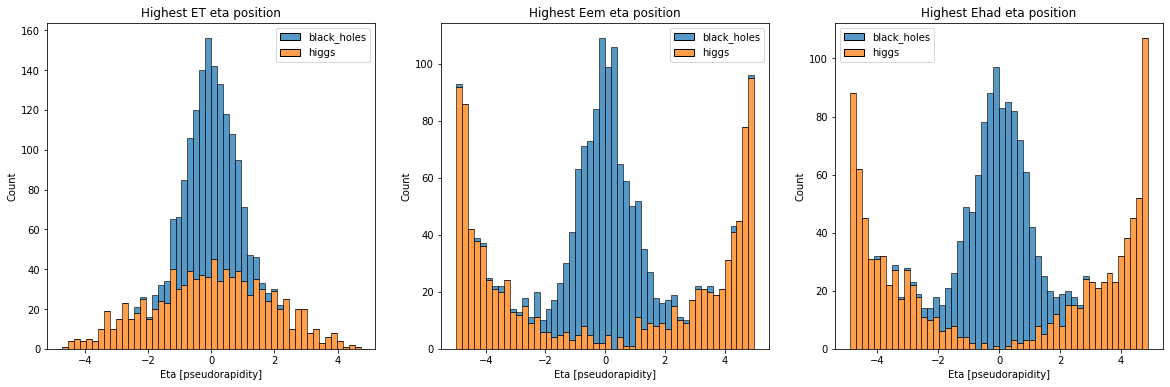

In [122]:
#Eta distribution
fig, ax = plt.subplots(ncols=3, figsize=(20,6))
sn.histplot({labels[0]: ET_eta[0], labels[1]: ET_eta[1]}, ax = ax[0], bins=50, multiple="stack", stat="count")
ax[0].set_xlabel("Eta [pseudorapidity]")
ax[0].set_title("Highest ET eta position")

sn.histplot({labels[0]: Eem_eta[0], labels[1]: Eem_eta[1]}, ax = ax[1], bins=50, multiple="stack", stat="count")
ax[1].set_xlabel("Eta [pseudorapidity]")
ax[1].set_title("Highest Eem eta position")

sn.histplot({labels[0]: Ehad_eta[0], labels[1]: Ehad_eta[1]}, ax = ax[2], bins=50, multiple="stack", stat="count")
ax[2].set_xlabel("Eta [pseudorapidity]")
ax[2].set_title("Highest Ehad eta position")


Text(0.5, 1.0, 'Highest Ehad phi position')

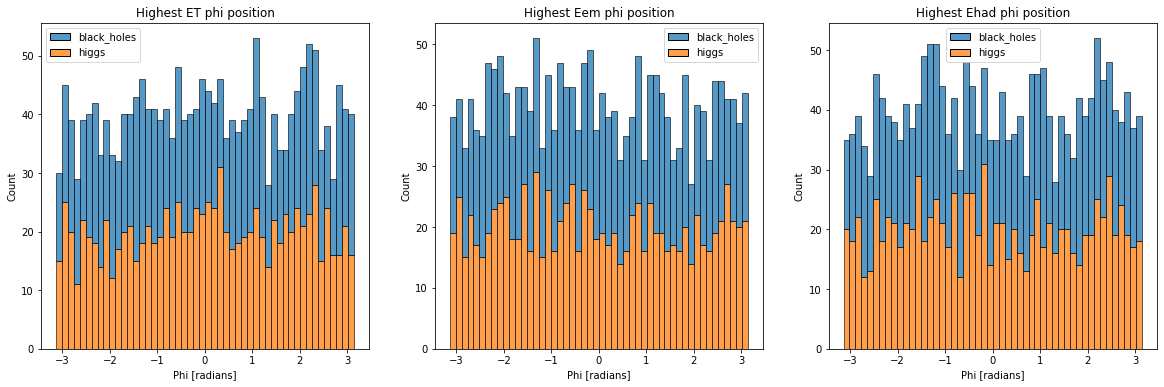

In [123]:
#phi distribution
fig, ax = plt.subplots(ncols=3, figsize=(20,6))
sn.histplot({labels[0]: ET_phi[0], labels[1]: ET_phi[1]}, ax = ax[0], bins=50, binrange=[-np.pi,np.pi], multiple="stack", stat="count")
ax[0].set_xlabel("Phi [radians]")
ax[0].set_title("Highest ET phi position")

sn.histplot({labels[0]: Eem_phi[0], labels[1]: Eem_phi[1]}, ax = ax[1], bins=50, binrange=[-np.pi,np.pi], multiple="stack", stat="count")
ax[1].set_xlabel("Phi [radians]")
ax[1].set_title("Highest Eem phi position")

sn.histplot({labels[0]: Ehad_phi[0], labels[1]: Ehad_phi[1]}, ax = ax[2], bins=50, binrange=[-np.pi,np.pi], multiple="stack", stat="count")
ax[2].set_xlabel("Phi [radians]")
ax[2].set_title("Highest Ehad phi position")

Text(0.5, 1.0, 'Highest Ehad deposit')

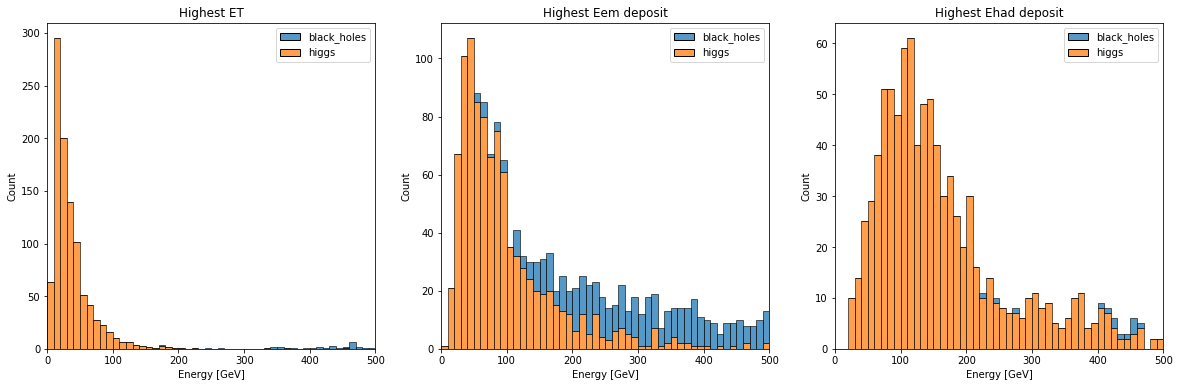

In [108]:
#energy distribution
fig, ax = plt.subplots(ncols=3, figsize=(20,6))
sn.histplot({labels[0]: ET_energy[0], labels[1]: ET_energy[1]}, ax = ax[0], bins=50, binrange=[0, 500], multiple="stack", stat="count")
#sn.histplot({labels[0]: ET_energy[0], labels[1]: ET_energy[1]}, ax = ax[0], kde=True, multiple="stack", stat="count")
ax[0].set_xlabel("Energy [GeV]")
ax[0].set_xlim(0, 500)
ax[0].set_title("Highest ET")

sn.histplot({labels[0]: Eem_energy[0], labels[1]: Eem_energy[1]}, ax = ax[1], bins=50, binrange=[0, 500], multiple="stack", stat="count")
ax[1].set_xlabel("Energy [GeV]")
ax[1].set_xlim(0, 500)
ax[1].set_title("Highest Eem deposit")

sn.histplot({labels[0]: Ehad_energy[0], labels[1]: Ehad_energy[1]}, ax = ax[2], bins=50, binrange=[0, 500], multiple="stack", stat="count")
ax[2].set_xlabel("Energy [GeV]")
ax[2].set_xlim(0, 500)
ax[2].set_title("Highest Ehad deposit")

Text(0.5, 1.0, 'Highest Ehad deposit')

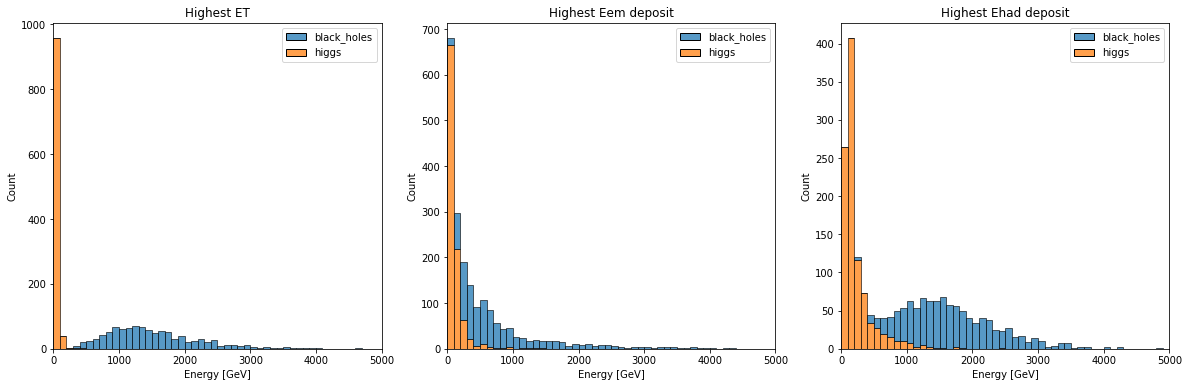

In [109]:
#energy distribution
fig, ax = plt.subplots(ncols=3, figsize=(20,6))
sn.histplot({labels[0]: ET_energy[0], labels[1]: ET_energy[1]}, ax = ax[0], bins=50, binrange=[0, 5000], multiple="stack", stat="count")
#sn.histplot({labels[0]: ET_energy[0], labels[1]: ET_energy[1]}, ax = ax[0], kde=True, multiple="stack", stat="count")
ax[0].set_xlabel("Energy [GeV]")
ax[0].set_xlim(0, 5000)
ax[0].set_title("Highest ET")

sn.histplot({labels[0]: Eem_energy[0], labels[1]: Eem_energy[1]}, ax = ax[1], bins=50, binrange=[0, 5000], multiple="stack", stat="count")
ax[1].set_xlabel("Energy [GeV]")
ax[1].set_xlim(0, 5000)
ax[1].set_title("Highest Eem deposit")

sn.histplot({labels[0]: Ehad_energy[0], labels[1]: Ehad_energy[1]}, ax = ax[2], bins=50, binrange=[0, 5000], multiple="stack", stat="count")
ax[2].set_xlabel("Energy [GeV]")
ax[2].set_xlim(0, 5000)
ax[2].set_title("Highest Ehad deposit")

Text(0.5, 1.0, 'Highest Ehad')

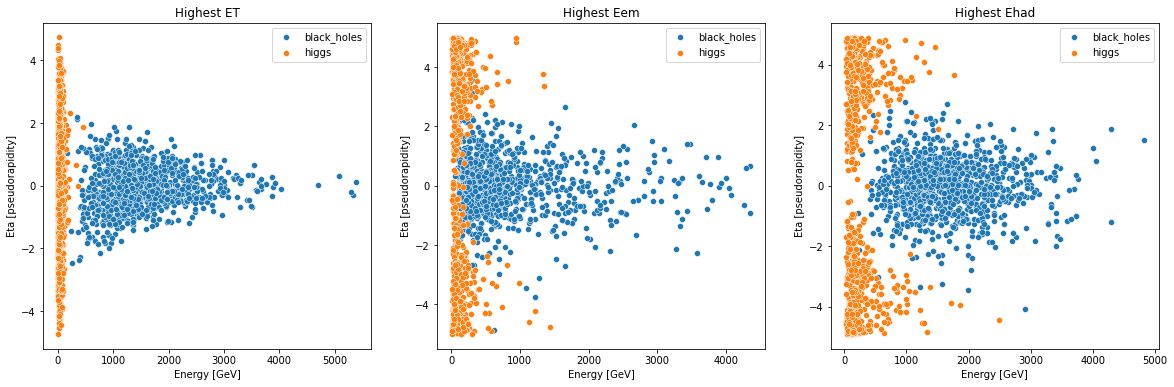

In [110]:
#energy distribution
fig, ax = plt.subplots(ncols=3, figsize=(20,6))
sn.scatterplot(x=ET_energy[0], y=ET_eta[0], ax = ax[0], label=labels[0])
sn.scatterplot(x=ET_energy[1], y=ET_eta[1], ax = ax[0], label=labels[1])
ax[0].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("Eta [pseudorapidity]")
ax[0].set_title("Highest ET")

sn.scatterplot(x=Eem_energy[0], y=Eem_eta[0], ax = ax[1], label=labels[0])
sn.scatterplot(x=Eem_energy[1], y=Eem_eta[1], ax = ax[1], label=labels[1])
ax[1].set_xlabel("Energy [GeV]")
ax[1].set_ylabel("Eta [pseudorapidity]")
ax[1].set_title("Highest Eem")

sn.scatterplot(x=Ehad_energy[0], y=Ehad_eta[0], ax = ax[2], label=labels[0])
sn.scatterplot(x=Ehad_energy[1], y=Ehad_eta[1], ax = ax[2], label=labels[1])
ax[2].set_xlabel("Energy [GeV]")
ax[2].set_ylabel("Eta [pseudorapidity]")
ax[2].set_title("Highest Ehad")

In [111]:
#Converting to images
MAX_EVENTS = 100
RESOLUTION = 80

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    Cal = [histogram2d(x[i], y[i], 
            range=[[-np.pi, np.pi], [-5, 5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
    return Cal


hists = create_histograms(ak.to_numpy(clusters[0].Phi), ak.to_numpy(clusters[0].Eta), ak.to_numpy(clusters[0].Ehad))
label = labels[0]

Showing images for black_holes


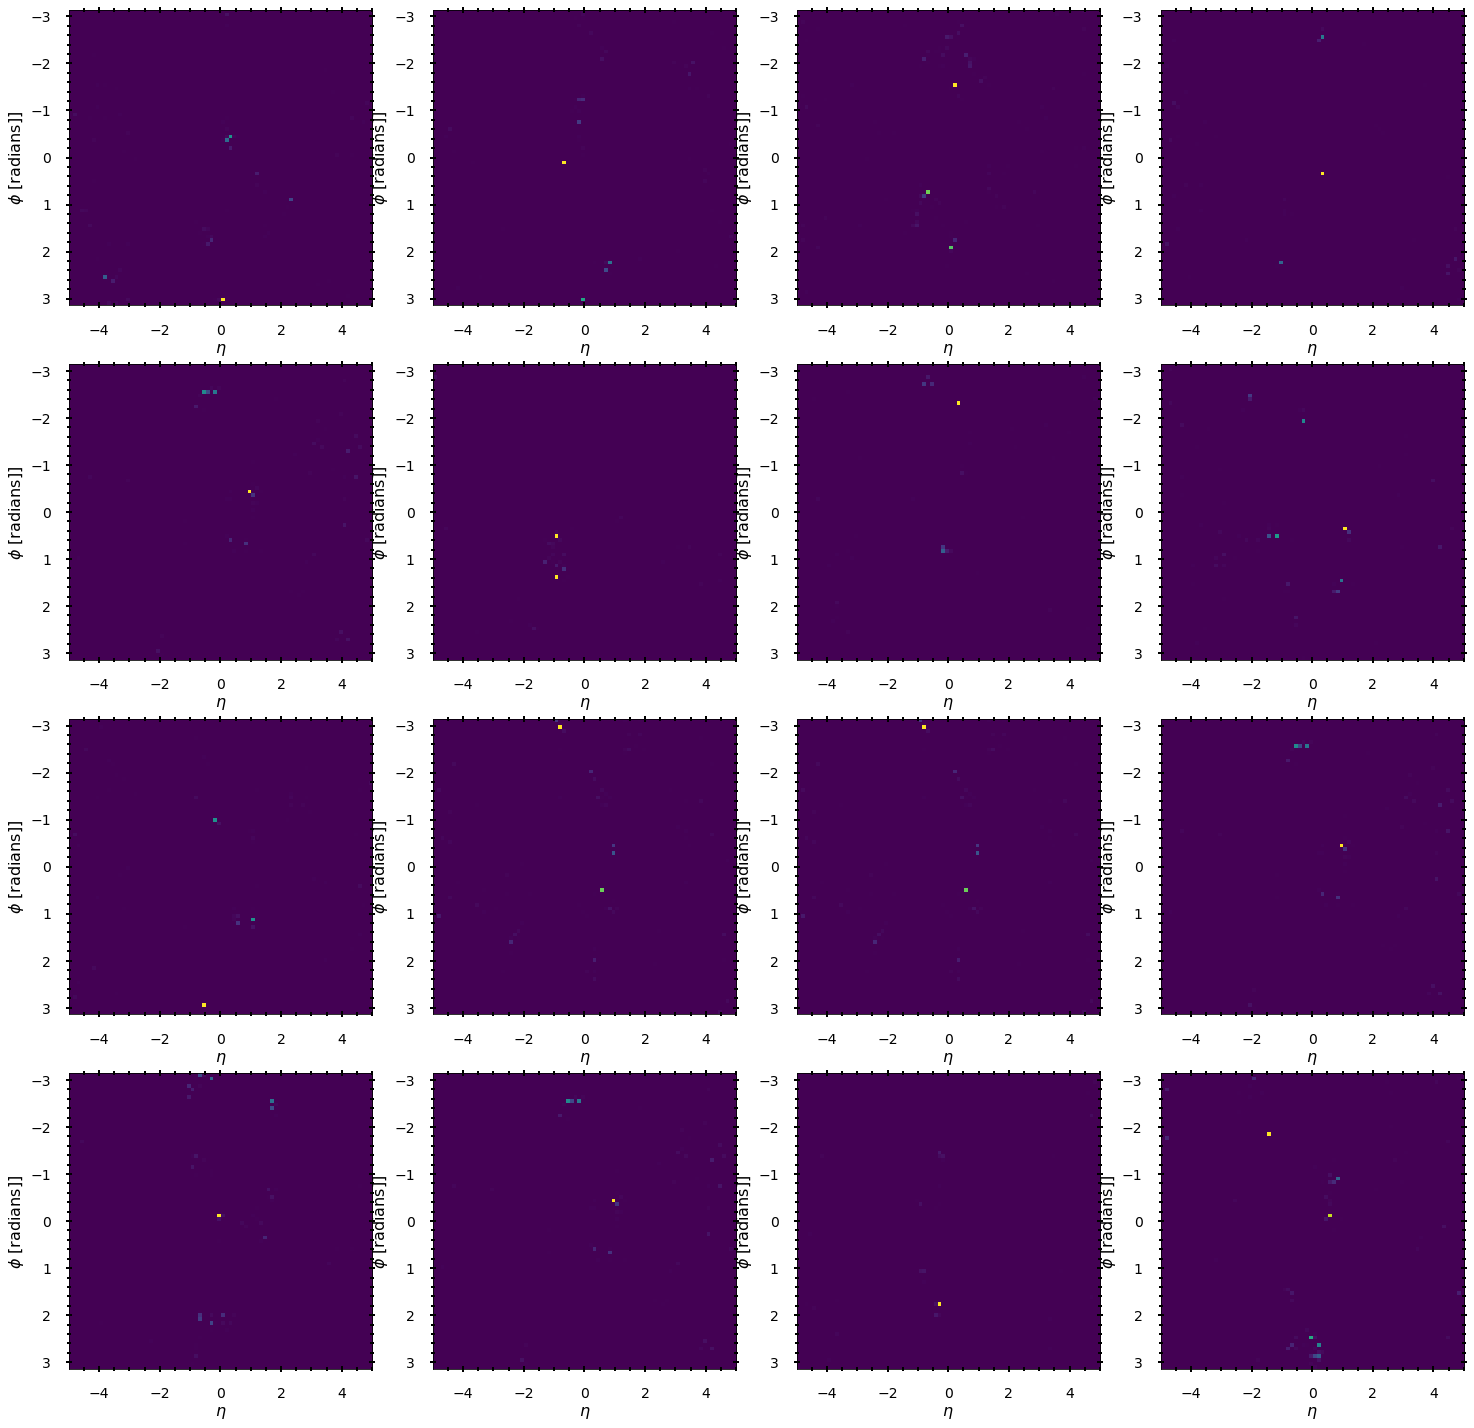

In [112]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(hists), size=(4,4))
print("Showing images for", label)
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(hists[images[i][j]], extent=[-5, 5, np.pi, -np.pi], aspect='auto')

In [113]:
#Converting to images
MAX_EVENTS = 100
RESOLUTION = 80

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    
    Cal = [histogram2d(x[i], y[i], 
            range=[[-np.pi, np.pi], [-5, 5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
            
    return Cal


hists = create_histograms(ak.to_numpy(clusters[1].Phi), ak.to_numpy(clusters[1].Eta), ak.to_numpy(clusters[1].Eem))
label = labels[1]

Showing images for higgs


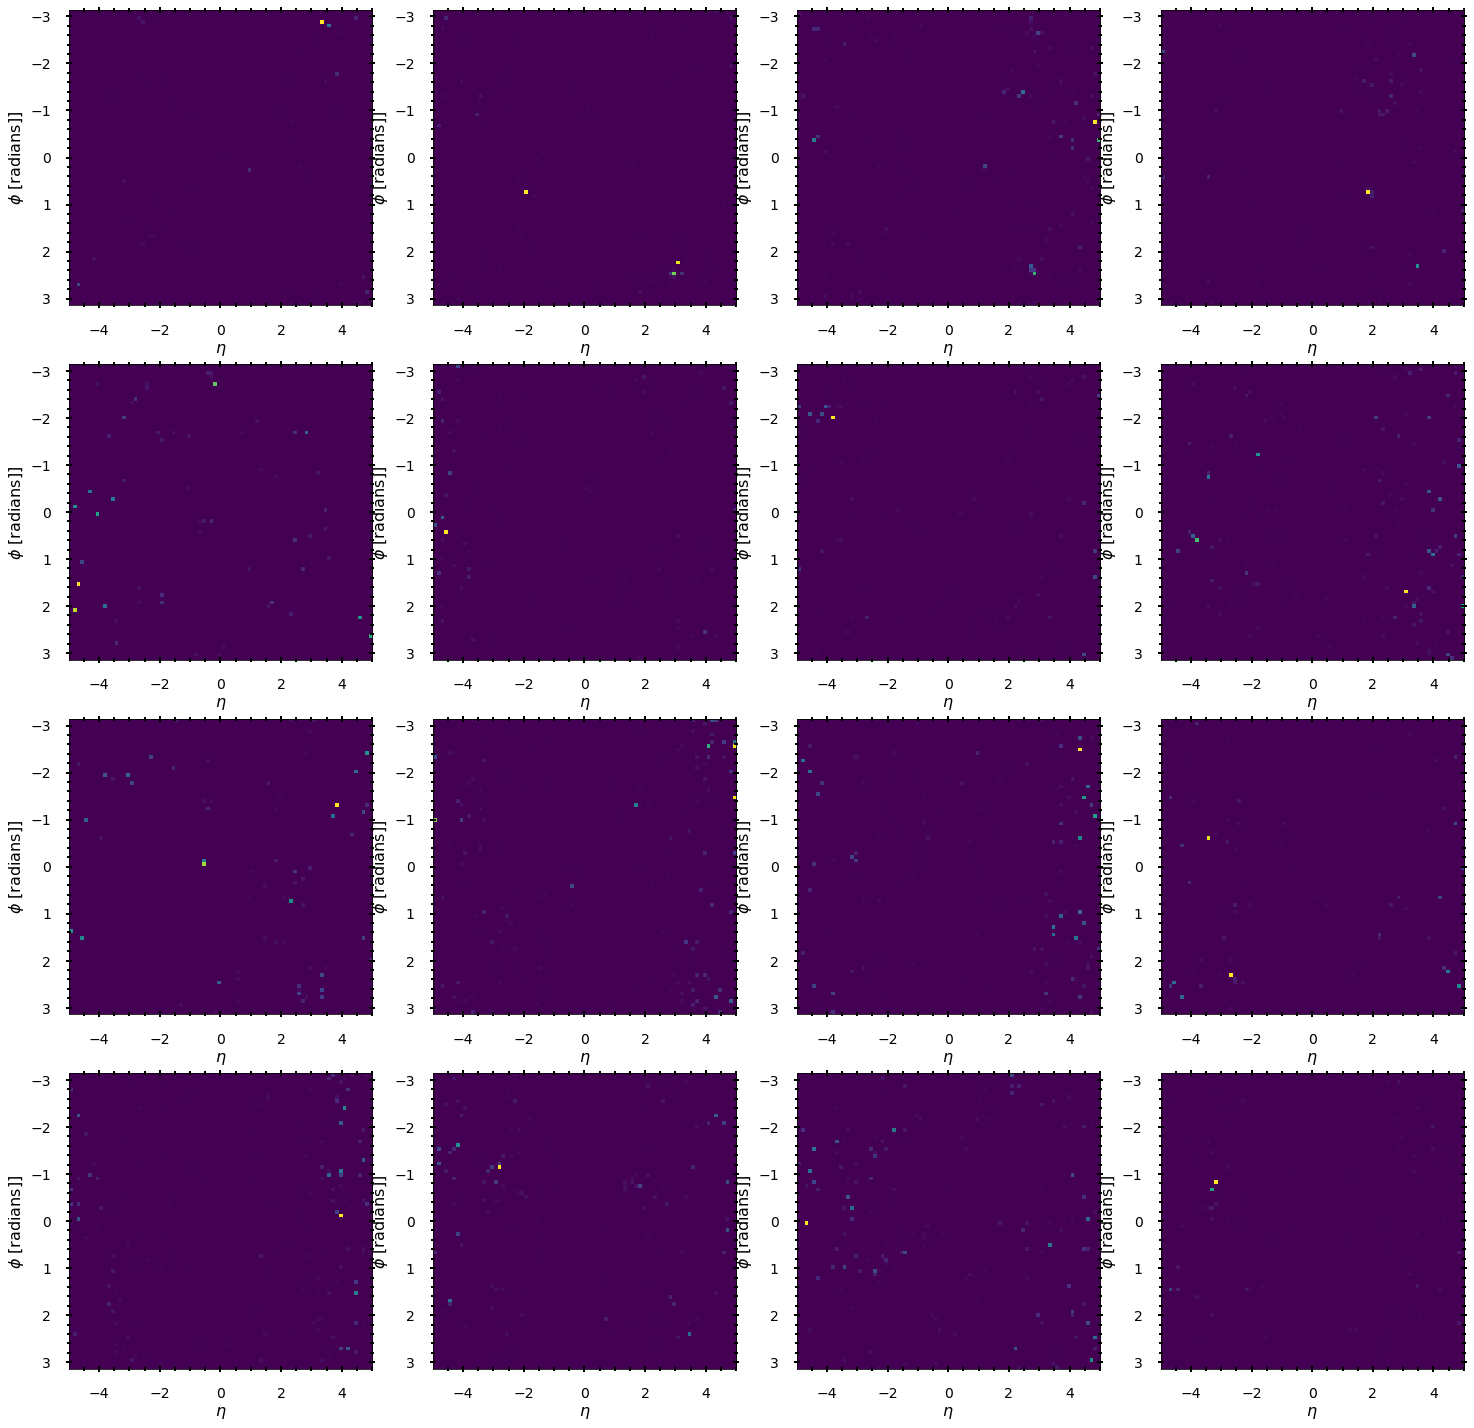

In [114]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(hists), size=(4,4))
print("Showing images for", label)
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(hists[images[i][j]], extent=[-5, 5, np.pi, -np.pi], aspect='auto')

Text(0.5, 0, 'Tower transverse energy')

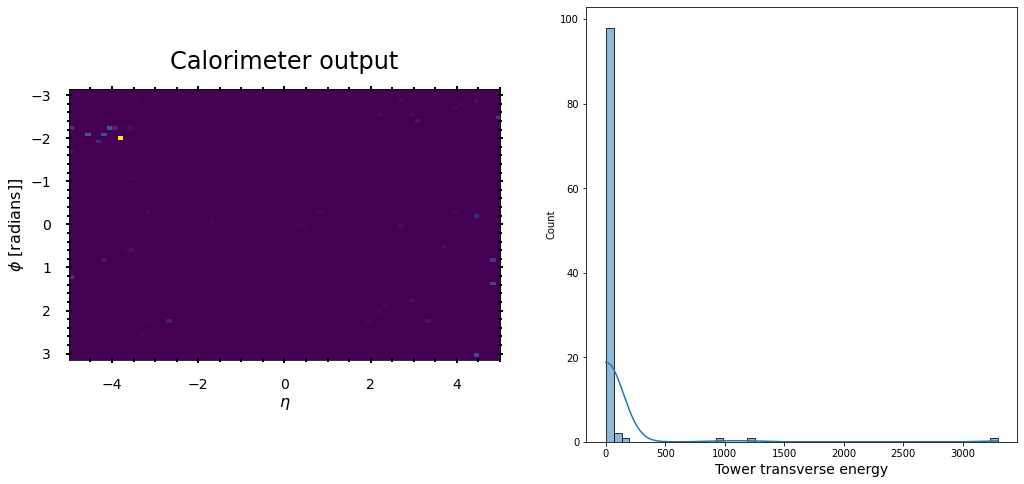

In [115]:
k = 2 #np.random.randint(0, high=len(hists)) #a random image
ET_list = ak.to_list(clusters[0].ET[k])
def cal_image_plot(ax):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    ax.set_title("Calorimeter output", fontsize=24, color="black", pad=20)
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 8))
cal_image_plot(axs[0])
axs[0].imshow(hists[k], extent=[-5, 5, np.pi, -np.pi], aspect='equal')
sn.histplot(ET_list, ax = axs[1], bins=50, kde=True, stat="count")
axs[1].set_xlabel("Tower transverse energy", fontsize=14)